In [10]:
# 读取数据集
# 下载地址：http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip
import os
import torch
import dltools


"""载入“英语－法语”数据集"""

with open('E:/data/fra-eng/fra.txt', 'r',encoding='utf-8') as f:
    raw_text = f.read()

print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [2]:
# 数据处理

def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [3]:
# 词元化
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

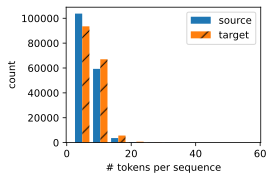

In [4]:
#     """绘制列表长度对的直方图"""
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    dltools.set_figsize()
    _, _, patches = dltools.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    dltools.plt.xlabel(xlabel)
    dltools.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    dltools.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence','count', source, target);

In [5]:
# 词表
src_vocab = dltools.Vocab(source, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [6]:
# 加载数据集
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
# 将机器翻译的文本序列转换成小批量
def build_array_nmt(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [23]:
# 训练模型
def load_data_nmt(batch_size, num_steps,num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(raw_text)
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = dltools.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = dltools.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = dltools.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [24]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[  7, 104,   4,   3,   1,   1,   1,   1],
        [  6, 123,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[  6,  27, 166,  17,   4,   3,   1,   1],
        [  6,   7, 132,   0,   0,   4,   3,   1]], dtype=torch.int32)
Y的有效长度: tensor([6, 7])
